For i in I iterations (e.g. 1000)

Create a random distribution of points

Create spatial weights matrix

For $\rho$ in `[0, 0.2, 0.4, 0.8, 1]`

Use spatial autoregressive model $Y = (I - \rho W)^{-1} \epsilon$ to generate autocorrelated variable for each point

Loop over each sample size `["3%","5%","10%","20%","50%","100%"]`

and then over each grid size `["6x6","8x8","10x10","12x12","15x15"]`

Aggregating the sampled points to each grid cell.

Computing global spatial autocorrelation stats

And plotting simple choropleths of each to show how results vary

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import geoplot
import shapely
import pysal
import matplotlib.pyplot as plt
import time

# constat data gen variables
total_points = 10000
knn_for_W = 30
iterations = 10

# storing outputs in a simple python list
outputs = []

# load in grid data (was generated in QGIS by hand)
grid_6 = gpd.read_file("grids/grid_6x6.geojson")
grid_8 = gpd.read_file("grids/grid_8x8.geojson")
grid_10 = gpd.read_file("grids/grid_10x10.geojson")
grid_12 = gpd.read_file("grids/grid_12x12.geojson")
grid_15 = gpd.read_file("grids/grid_15x15.geojson")

# setup lists for looping samples and grids
grids = [grid_6, grid_8, grid_10, grid_12, grid_15]
samples = ["sample_03","sample_05","sample_10","sample_20","sample_50","sample_100"]
sample_names = ["3%","5%","10%","20%","50%","100%"]
grid_names = ["6x6","8x8","10x10","12x12","15x15"]

# timing
start_time = time.time()

# start iterating over iterations
i = 0
while i < iterations:
    
    print(i, start_time - time.time())

    # generate random location of points
    xy = 1.2 * np.random.rand(total_points,2)
    xydf = pd.DataFrame(data=xy)
    xydf.columns = ['x', 'y']

    # standard normal errors for each point
    errors_ind = np.random.normal(0, 1, total_points)
    xydf["errors"] = errors_ind

    # an identiy matrix needed for generating simulated values at each point
    I = np.identity(total_points)
    
    # weights matrix for k nearest
    kd = pysal.lib.cg.kdtree.KDTree(xy)
    W = pysal.lib.weights.KNN(kd, knn_for_W)
    W.transform = 'r' # row normalizing

    # extract the sparse weights matrix as a full np array for matrix multiplication
    W = (W.sparse)
    W = (W.toarray())
    
    for rho in [0, 0.2, 0.4, 0.8, 1]:
        
        # spatial autoregression
        # $Y = (I - \rho W)^{-1} \epsilon$
        Y = np.matrix(I - rho * W).I.dot(errors_ind)
        
        # append these Y values to the point data frame
        xydf["sim"] = np.transpose(Y)
        
        # use binomial distribution to select whether point is sampled
        xydf["sample_03"] = np.random.binomial(1, 0.03, size=total_points)
        xydf["sample_05"] = np.random.binomial(1, 0.05, size=total_points)
        xydf["sample_10"] = np.random.binomial(1, 0.10, size=total_points)
        xydf["sample_20"] = np.random.binomial(1, 0.20, size=total_points)
        xydf["sample_50"] = np.random.binomial(1, 0.50, size=total_points)
        xydf["sample_100"] = np.random.binomial(1, 1, size=total_points) 
        
        outputs = []

        s = 0
        for sample in samples:

            # subset data by each sample
            xydf_s = xydf.loc[(xydf[sample] == 1)]

            # set up a geodataframe for this, to allow for future spatial join
            geometry = [shapely.geometry.Point(xy) for xy in zip(xydf_s.x, xydf_s.y)]
            gdf = gpd.GeoDataFrame(xydf_s,  geometry=geometry)

            g = 0
            for grid in grids:

                # spatial join the grid IDs to the point data
                xy_with_grid = gpd.sjoin(gdf, grid, how="inner", op='intersects')

                # generate means and proportions in each cell of the grid
                grid_desc = xy_with_grid.groupby(['id']).agg({'errors': "count",'sim': "mean"})

                # update some of the column names
                grid_desc["mean"] = grid_desc["sim"]
                del grid_desc['sim'], grid_desc['errors']

                # join back to grid boundaries
                grid_join = grid.merge(grid_desc, on='id')

                # compute spatial weights matrix
                Wg = pysal.lib.weights.Queen.from_dataframe(grid_join)
                Wg.transform = 'r' # row normalizing

                mi = pysal.explore.esda.Moran(np.array(grid_join["mean"]), Wg, two_tailed=False)

                #YVar='mean'
                #XVars=['id'] 
                Ym=grid_join['mean'].values.reshape((len(grid_join),1))
                Xm=grid_join[['id']].values
                mlag = pysal.model.spreg.ml_lag.ML_Lag(Ym,Xm,w=Wg,name_y='mean', name_x=['id'] )

                # output the values
                output = [sample_names[s], grid_names[g], round(mi.I, 3), round(mi.p_norm, 3), round(mlag.rho,3),  round(mlag.z_stat[2][1],3)]
                outputs.append(output)

                g += 1

            s += 1

    i += 1
    
    

0 -0.0010797977447509766


/home/ja/miniconda3/envs/map/lib/python3.7/site-packages/scipy/optimize/_minimize.py:761: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


Exception: power expansion will not converge, check model specification and that weight are less than 1

Generate a spatial weights matrix for the points based on $k$ nearest neighbours

Pick a $\rho$ for generating spatiall correlated values at each point, then run spatial autoregressive process

In [4]:
rho = 0.4

In [5]:
%%time 


CPU times: user 1min 12s, sys: 1.82 s, total: 1min 14s
Wall time: 32.3 s


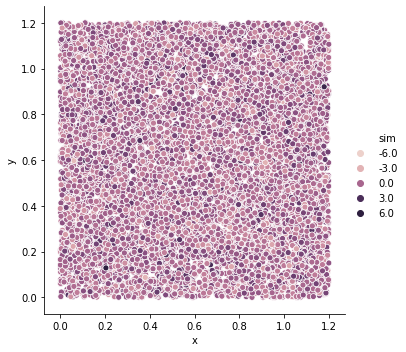

In [7]:
# plot if we want to see the points with colours
sns.relplot(x="x", y="y", hue="sim",data=xydf);

In [8]:
# also convert these Y values to a binary (1,0) if we want to analyze zonal proportions (where mean = 0.5)
simmean = xydf["sim"].mean()
xydf['sim_b'] = 0
xydf['sim_b'][xydf['sim'] > simmean] = 1

/home/ja/miniconda3/envs/map/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [11]:
# add in binomial distribution for whether observation is sampled or not, 
# do this for several sampling rates [0.03,0.05,0.1,0.2,0.5,1.0]


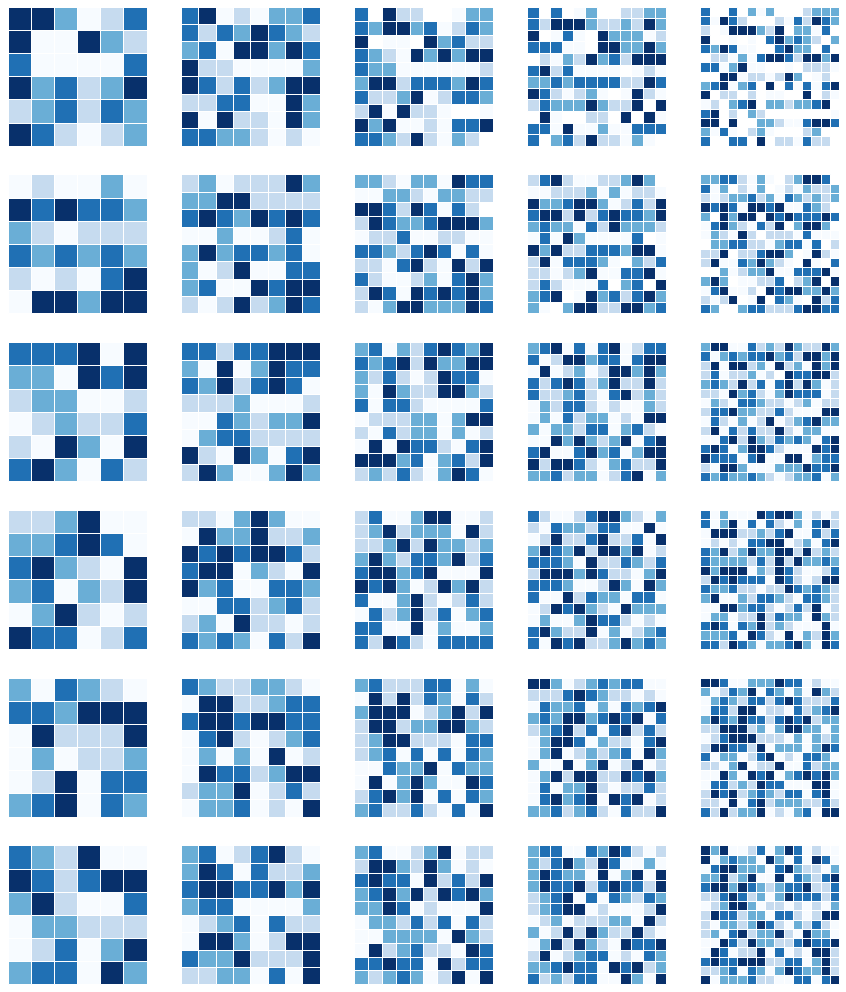

In [42]:
outputs

[['6x6', 0.061, 0.158, 0.1070199268476711, 0.690600821890696],
 ['8x8', 0.162, 0.004, 0.4011823633823063, 0.01843255117339593],
 ['10x10', 0.207, 0.0, 0.5062756047846448, 5.1549358685323214e-05],
 ['12x12', 0.255, 0.0, 0.5830701216089251, 1.2636013008836906e-09],
 ['15x15', 0.328, 0.0, 0.6890690508645636, 7.385633380997677e-26]]